In [30]:
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
####Loading directories
good_dir = Path("/home/tharushi/Desktop/hackathon/10061/patches_128/particles")         
bad_dir  = Path("/home/tharushi/Desktop/hackathon/10061/patches_128/false_positives")

good_files = sorted(good_dir.glob("*.png"))
bad_files  = sorted(bad_dir.glob("*.png"))

print("GOOD:", len(good_files), "BAD:", len(bad_files))

GOOD: 35218 BAD: 40814


In [32]:
###defining FFT power spectrum function and a score to select bad ice

def fft_power_spectrum(patch_u8: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """
    Input: 2D patch (uint8 or float). Output: 2D float32 FFT power spectrum normalized to [0,1].
    """
    x = patch_u8.astype(np.float32)

    # optional: mean-center to reduce DC spike
    x = x - x.mean()

    # FFT -> shift zero frequency to center
    F = np.fft.fft2(x)
    F = np.fft.fftshift(F)

    # power spectrum (magnitude^2) then log for visibility
    P = (np.abs(F) ** 2)
    P = np.log1p(P)  # log(1+P) stabilizes dynamic range

    # normalize to [0,1]
    P = (P - P.min()) / (P.max() - P.min() + eps)
    return P.astype(np.float32)

In [33]:
def load_patch_gray(path: Path) -> np.ndarray:
    img = imageio.imread(path)
    if img.ndim == 3:  # if RGB, convert to gray
        img = img[..., 0]
    return img

p = load_patch_gray(good_files[0])  # try one GOOD patch
fft_p = fft_power_spectrum(p)

print(p.shape, p.dtype, fft_p.shape, fft_p.dtype)


(128, 128) uint8 (128, 128) float32


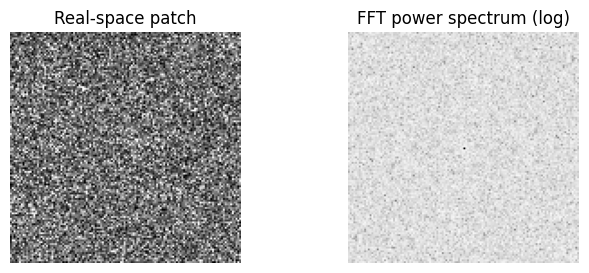

In [34]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(p, cmap="gray")
plt.title("Real-space patch")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fft_p, cmap="gray")
plt.title("FFT power spectrum (log)")
plt.axis("off")

plt.show()

In [35]:
def make_Xy_from_folders(good_files, bad_files, max_per_class=None):
    if max_per_class is not None:
        good_files = good_files[:max_per_class]
        bad_files  = bad_files[:max_per_class]

    X_list, y_list, paths = [], [], []

    # GOOD = 1
    for f in good_files:
        patch = load_patch_gray(f).astype(np.float32) / 255.0
        fft_p = fft_power_spectrum((patch * 255.0).astype(np.uint8))  # FFT from original scale is fine
        X = np.stack([patch, fft_p], axis=0)  # (2, H, W)
        X_list.append(X)
        y_list.append(1)
        paths.append(str(f))

    # BAD = 0
    for f in bad_files:
        patch = load_patch_gray(f).astype(np.float32) / 255.0
        fft_p = fft_power_spectrum((patch * 255.0).astype(np.uint8))
        X = np.stack([patch, fft_p], axis=0)
        X_list.append(X)
        y_list.append(0)
        paths.append(str(f))

    X = np.stack(X_list, axis=0).astype(np.float32)  # (N,2,H,W)
    y = np.array(y_list, dtype=np.int64)
    return X, y, paths

X, y, paths = make_Xy_from_folders(good_files, bad_files, max_per_class=2000)  # adjust
print("X:", X.shape, X.dtype, "y:", y.shape, "pos rate:", y.mean())


X: (4000, 2, 128, 128) float32 y: (4000,) pos rate: 0.5


In [36]:
out_npz = Path("real_plus_fft_dataset_128.npz")
np.savez_compressed(out_npz, X=X, y=y, paths=np.array(paths))
print("Saved:", out_npz)
    

Saved: real_plus_fft_dataset_128.npz
